# EnMAP matched-filter diagnostics and uncertainty propagation

This notebook reproduces the matched-filter pre-processing steps (radiance ingestion, band selection, clustering, target synthesis, SNR mapping) to explain how $\sigma_{RMN}$ is produced before being combined with plume-level clutter estimates in the uncertainty-analysis workflow.


## 1. Load radiances, metadata, and configuration
Initialise the repository context, declare the EnMAP scene assets (VNIR/SWIR GeoTIFFs, DEM, LUT, SNR reference), and read the radiance cube plus centre wavelengths/FWHM via `enmap_utils`. The summary statistics double-check that the inputs are finite and that the configuration matches the Agadez test scene.


In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal

NOTEBOOK_ROOT = Path.cwd().resolve()
REPO_ROOT = NOTEBOOK_ROOT.parent
os.environ.setdefault('PYTHONPATH', str(REPO_ROOT))
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

from scripts.pipelines import enmap_pipeline
from scripts.core import noise, targets, lut, matched_filter
from scripts.satellites import enmap_utils

ENMAP_CONFIG = {
    'data_dir': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/enmap/Agadez_Niger_20220712/L1B-DT0000001584_20220712T104302Z_001_V010502_20251017T093724Z'),
    'dem': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/DEM_1Km/srtm30plus_v11_land.nc'),
    'lut': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/LUTs/CH4_lut.hdf5'),
    'snr_reference': REPO_ROOT / 'notebooks' / 'outputs' / 'enmap' / 'L1B-DT0000001584_20220712T104302Z_001_V010502_20251017T093724Z' / 'snr_reference_columnwise.npz',
    'output_dir': NOTEBOOK_ROOT / 'notebooks' / 'outputs' / 'pipeline_diagnostics_enmap',
    'min_wavelength': 2100.0,
    'max_wavelength': 2450.0,
    'k': 1,
}

CONFIG = ENMAP_CONFIG
CONFIG['output_dir'].mkdir(parents=True, exist_ok=True)
print('Configuration loaded.')

# Load radiance data
vnir_path, swir_path, xml_path = enmap_utils.find_enmap_files(str(CONFIG['data_dir']))
rads_array, cw_array, fwhm_array, _, _, _ = enmap_utils.enmap_read(vnir_path, swir_path, xml_path)

# Print shape and summary statistics
print(f'Rads array shape: {rads_array.shape}')
print(f'Rads array min: {np.nanmin(rads_array)}')
print(f'Rads array max: {np.nanmax(rads_array)}')
print(f'Rads array mean: {np.nanmean(rads_array)}')


Configuration loaded.
Rads array shape: (1024, 1000, 224)
Rads array min: -0.013795738108456135
Rads array max: 20.197147369384766
Rads array mean: 7.477053165435791


## 2. Restrict to the methane absorption window
`targets.select_band_indices` keeps only bands between `min_wavelength` and `max_wavelength` (2.1-2.45 um here), producing consistent wavelength/FWHM subsets that drive both the matched filter and the SNR reference mapping. This isolates the CH$\_4$ absorption triplet while avoiding noisy edges.


In [2]:
# Subselect bands
band_indices = targets.select_band_indices(cw_array, CONFIG['min_wavelength'], CONFIG['max_wavelength'])
rads_array_subselection = rads_array[:, :, band_indices]
cw_subselection = cw_array[band_indices]
fwhm_subselection = fwhm_array[band_indices]

print(f'Subselected rads array shape: {rads_array_subselection.shape}')


Subselected rads array shape: (1024, 1000, 43)


## 3. Background clustering and statistics
Apply k-means (`k=1` for this scene) to build the background classification mask, then derive the mean radiance vector $\mu$ and covariance matrices $\Sigma$ per cluster. These statistics parameterise the matched filter weights $w = \Sigma^{-1}(t-\mu)$ and implicitly assume column-wise stationarity within each cluster.


In [3]:
# k-means classification
classified_image = matched_filter.k_means_hyperspectral(rads_array_subselection, CONFIG['k'])
mean_radiance, covariance_matrices = matched_filter.calculate_statistics(rads_array_subselection, classified_image, CONFIG['k'])

print(f'Mean radiance shape: {mean_radiance.shape}')
print(f'Covariance matrices shape: {covariance_matrices.shape}')


Mean radiance shape: (1, 43)
Covariance matrices shape: (1, 43, 43)


## 4. Generate target spectra from the LUT
Read the scene-average solar zenith angle, water vapour column, and ground elevation from the metadata, normalise them to LUT coordinates, and call `lut.generate_library`. `targets.generate_template_from_bands` resamples the simulated spectra onto the selected wavelengths to obtain the CH$\_4$ template vector `target_spectra`. This approximates the differential absorbance expected for increasing path-integrated concentrations.


In [4]:
# Generate target spectra
SZA, meanWV, mean_ground_elevation = enmap_utils.enmap_metadata_read(xml_path)
mean_elevation_km = mean_ground_elevation / 1000.0

concentrations = [0.0, 1000, 2000, 4000, 8000, 16000, 32000, 64000]
ground_km = lut.normalize_ground_km(mean_elevation_km)
water_gcm2 = lut.normalize_wv_gcm2(meanWV)

simRads_array, simWave_array = lut.generate_library(
    concentrations, str(CONFIG['lut']), zenith=SZA, sensor=120, ground=ground_km, water=water_gcm2, order=1
)

target_i = targets.generate_template_from_bands(
    cw_subselection,
    fwhm_subselection,
    simRads_array,
    simWave_array,
    concentrations,
)
target_spectra = target_i[:, 1]

print(f'Target spectra shape: {target_spectra.shape}')
print(f'Target spectra min: {np.nanmin(target_spectra)}')
print(f'Target spectra max: {np.nanmax(target_spectra)}')
print(f'Target spectra mean: {np.nanmean(target_spectra)}')


Sun Zenith Angle (degrees): 9.0
Mean Water Vapor (g/cm^2): 2.756
Mean Ground Elevation (m): 546.404
Target spectra shape: (43,)
Target spectra min: -1.1183086663738471e-05
Target spectra max: -2.1997670652095035e-09
Target spectra mean: -3.712578723319529e-06


## 5. Map the columnwise SNR reference to the scene cube
Load the precomputed `ColumnwiseSNRReference`, subset it to the retained wavelengths, enforce the correct column count, and compute `sigma_cube = L / SNR` by transposing the radiance cube to `(bands, rows, cols)`. This stage assumes the reference SNR captures detector noise for the same calibration state as the scene.


In [5]:
# Load SNR reference and compute sigma_cube
reference = noise.ColumnwiseSNRReference.load(str(CONFIG['snr_reference']))
reference_subset = reference.subset_by_wavelengths(cw_subselection).ensure_column_count(
    rads_array_subselection.shape[1]
)
rad_cube_brc = np.transpose(rads_array_subselection, (2, 0, 1))
sigma_cube = noise.compute_sigma_map_from_reference(reference_subset, rad_cube_brc)

print(f'Sigma cube shape: {sigma_cube.shape}')
print(f'Sigma cube min: {np.nanmin(sigma_cube)}')
print(f'Sigma cube max: {np.nanmax(sigma_cube)}')
print(f'Sigma cube mean: {np.nanmean(sigma_cube)}')


Sigma cube shape: (43, 1024, 1000)
Sigma cube min: 0.0013957258063836857
Sigma cube max: 0.012347212569456822
Sigma cube mean: 0.0037895198172401934


## 6. Propagate per-pixel RMN uncertainty
`noise.propagate_rmn_uncertainty` ingests the noise cube, classification, mean radiance, and target spectra to evaluate $\sigma_{RMN} = \sqrt{w^\top \Sigma_{noise} w}$ per pixel. The resulting map is displayed in ppm·m, highlighting where detector noise alone limits the matched-filter sensitivity (before adding clutter terms).


Sigma RMN shape: (1024, 1000)
Sigma RMN min: 129.9665069580078
Sigma RMN max: 149.74928283691406
Sigma RMN mean: 140.15919494628906


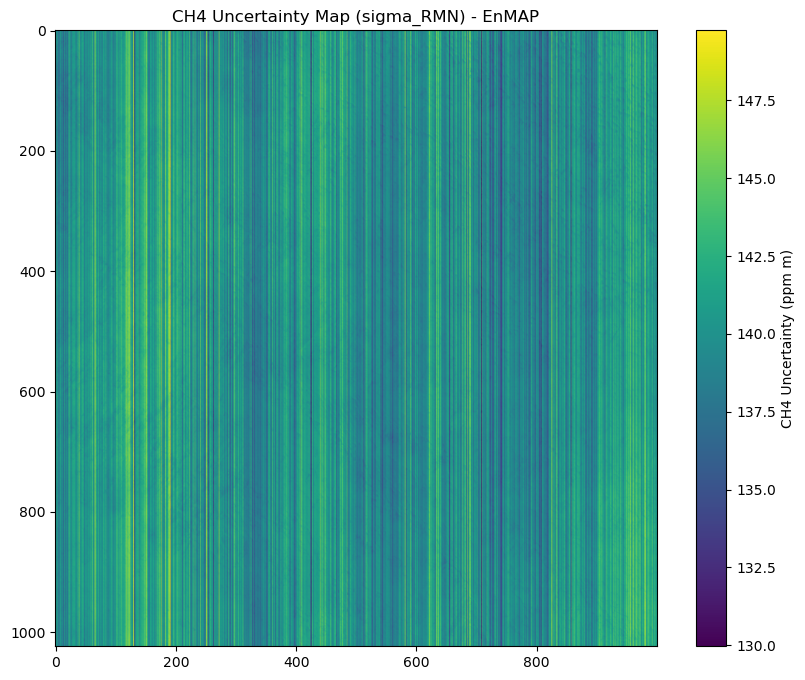

In [6]:
# Propagate uncertainty
sigma_rmn = noise.propagate_rmn_uncertainty(
    sigma_cube=sigma_cube,
    classified_image=classified_image,
    mean_radiance=mean_radiance,
    target_spectra=target_spectra,
).astype(np.float32)

print(f'Sigma RMN shape: {sigma_rmn.shape}')
print(f'Sigma RMN min: {np.nanmin(sigma_rmn)}')
print(f'Sigma RMN max: {np.nanmax(sigma_rmn)}')
print(f'Sigma RMN mean: {np.nanmean(sigma_rmn)}')

plt.figure(figsize=(10, 8))
plt.imshow(sigma_rmn, cmap='viridis')
plt.colorbar(label='CH4 Uncertainty (ppm m)')
plt.title('CH4 Uncertainty Map (sigma_RMN) - EnMAP')
plt.show()
